# Imports

In [2]:
import os
import sys
import importlib
import json
import uuid

import numpy as np
import pandas as pd
import scipy.ndimage as snd
import skimage
import cv2
from matplotlib import pyplot as plt
import matplotlib as mpl
import plotly.express as px
import plotly.graph_objects as go
import plotly

# !py -m pip install numpy
# !py -m pip install pandas
# !py -m pip install scipy
# !py -m pip install opencv-python
# !py -m pip install matplotlib
# !py -m pip install plotly

if os.getcwd().split("/")[-1] == "notebooks":  # if cwd is located where this file is
    os.chdir("../..")  # go two folders upward (the if statement prevents error if cell is rerun)
directory_path = os.path.abspath(os.path.join("src"))
if directory_path not in sys.path:
    sys.path.append(directory_path)
print(directory_path)

import EyeTraumaAnalysis

/Users/ryerrabelli/Library/CloudStorage/GoogleDrive-ryerrabelli@gmail.com/My Drive/Computer Backups/Rahul Yerrabelli drive/PythonProjects/EyeTraumaAnalysis/src
B
C
B
C


# Test how cv2.cvtColor(.) works with regards to uint8 vs float input

In [4]:
img_file_num = 14000
image = EyeTraumaAnalysis.Image(f"data/01_raw/{img_file_num}.png")
img_bgr = image.img

In [5]:
a1=cv2.cvtColor(np.float32(img_bgr)*2, cv2.COLOR_BGR2HSV)
b1=cv2.cvtColor(np.float32(img_bgr), cv2.COLOR_BGR2HSV)

a2 = cv2.cvtColor(a1, cv2.COLOR_HSV2BGR)
b2 = cv2.cvtColor(b1, cv2.COLOR_HSV2BGR)

a1m,b1m=np.max(a1[...,2]), np.max(b1[...,2])
a2m,b2m=np.max(a2[...,2]), np.max(b2[...,2])
(a1m,b1m,a1m/b1m), (a2m,b2m,a2m/b2m)

((510.0, 255.0, 2.0), (510.0, 255.0, 2.0))

In [6]:
a1=cv2.cvtColor(np.uint8(img_bgr), cv2.COLOR_BGR2HSV)
b1=cv2.cvtColor(np.float32(img_bgr)/255, cv2.COLOR_BGR2HSV)

a2 = cv2.cvtColor(a1, cv2.COLOR_HSV2BGR)
b2 = cv2.cvtColor(b1, cv2.COLOR_HSV2BGR)*255

a1m,b1m=np.max(a1[...,2]), np.max(b1[...,2])
a2m,b2m=np.max(a2[...,2]), np.max(b2[...,2])
(a1m,b1m,a1m/b1m), (a2m,b2m,a2m/b2m)

((255, 1.0, 255.0), (255, 255.0, 1.0))

In [7]:
a1=cv2.cvtColor(np.uint8(img_bgr), cv2.COLOR_BGR2HSV)
b1=cv2.cvtColor(np.float32(img_bgr), cv2.COLOR_BGR2HSV)

a2 = cv2.cvtColor(a1, cv2.COLOR_HSV2BGR)
b2 = cv2.cvtColor(b1, cv2.COLOR_HSV2BGR)

a1m,b1m=np.mean(a1[...,2]), np.mean(b1[...,2])
a2m,b2m=np.mean(a2[...,2]), np.mean(b2[...,2])
(a1m,b1m,a1m/b1m), (a2m,b2m,a2m/b2m)

((144.09047321242443, 144.09047, 1.0000000267337104),
 (89.91268352243962, 90.351974, 0.9951380037087425))

In [12]:
a1=cv2.cvtColor(np.uint8(img_bgr), cv2.COLOR_BGR2HSV)
b1=cv2.cvtColor(np.float32(img_bgr), cv2.COLOR_BGR2HSV)

a2 = cv2.cvtColor(a1, cv2.COLOR_HSV2BGR)
b2 = cv2.cvtColor(b1, cv2.COLOR_HSV2BGR)

a1m,b1m=np.max(a1, axis=(0,1)), np.max(b1, axis=(0,1))
a2m,b2m=np.max(a2, axis=(0,1)), np.max(b2, axis=(0,1))
(a1m,b1m,a1m/b1m), (a2m,b2m,a2m/b2m)

((array([177, 183, 255], dtype=uint8),
  array([354.54544,   0.71875, 255.     ], dtype=float32),
  array([  0.4992308, 254.60869  ,   1.       ], dtype=float32)),
 (array([255, 253, 255], dtype=uint8),
  array([255., 253., 255.], dtype=float32),
  array([1., 1., 1.], dtype=float32)))

# Display subplot analysis

In [8]:
def plot_kmeans_subplots_view(img_bgr, res_bgr, masks_summed):
    unique_vals = np.unique(masks_summed)
    bounds = np.arange(0,255,25)-12.5

    cmap2 = mpl.cm.gray
    norm2 = mpl.colors.BoundaryNorm(bounds, cmap2.N, extend='both')
    cmap3 = mpl.cm.terrain
    norm3 = mpl.colors.BoundaryNorm(bounds, cmap3.N, extend='both')

    fig, axs = plt.subplots(2, 2, figsize=(12,6))
    im0=axs.flat[0].imshow(img_bgr)
    im1=axs.flat[1].imshow(res_bgr)
    im2=axs.flat[2].imshow(masks_summed, cmap=cmap2)
    im3=axs.flat[3].imshow(masks_summed, cmap=cmap3)
    for ind in range(len(axs.flat)):
        axs.flat[ind].axis("off")  # takes off x and y axes ticks

    cbar2 = fig.colorbar(mpl.cm.ScalarMappable(norm=norm2, cmap=cmap2), ax=axs.flat[2],
                         ticks=unique_vals, orientation="horizontal")
    cbar3 = fig.colorbar(mpl.cm.ScalarMappable(norm=norm3, cmap=cmap3), ax=axs.flat[3], cmap="terrain",
                         ticks=unique_vals, orientation="horizontal", shrink=0.9)
    cbar2.ax.set_xticklabels([f"#{ind+1}" for ind in range(len(unique_vals))]);  # horizontal colorbar
    cbar3.ax.set_xticklabels([f"#{ind+1}" for ind in range(len(unique_vals))]);  # horizontal colorbar

    plt.tight_layout()

def plot_kmeans_subplots_view_simple(img_bgr, res_bgr, masks_summed):
    unique_vals = np.unique(masks_summed)
    bounds = np.arange(0,255,25)-12.5

    cmap2 = mpl.cm.terrain
    norm2 = mpl.colors.BoundaryNorm(bounds, cmap2.N, extend='both')

    fig, axs = plt.subplots(1, 3, figsize=(8,2))   # 1 row, 3 columns
    im0=axs.flat[0].imshow(img_bgr)
    im1=axs.flat[1].imshow(res_bgr)
    im2=axs.flat[2].imshow(masks_summed, cmap=cmap2)
    for ind in range(len(axs.flat)):
        axs.flat[ind].axis("off")  # takes off x and y axes ticks


    cbar2 = fig.colorbar(mpl.cm.ScalarMappable(norm=norm2, cmap=cmap2), ax=axs.flat[2],
                         ticks=unique_vals, orientation="horizontal")
    cbar2.ax.set_xticklabels([f"#{ind+1}" for ind in range(len(unique_vals))]);  # horizontal colorbar
    plt.tight_layout()

# Test running kmeans on different colorspaces and flaot vs uint8

In [9]:
img_file_num = 14000

## Run on HSV when BGR is uint8

  center            min            max               ct       
       H    S    V    H    S    V    H    S    V      #      %
0    145   46   40   87   84  124   87   84  124   6939  0.207
1    121   88   51    0   16  118    0   16  118   1035  0.031
2    117  122   57    0   17   16    0   17   16   2750  0.082
3    127   51   95  112    8  127  112    8  127   1115  0.033
4    114  109  104   84   73  -96   84   73  -96  15068  0.449
5    117   63  145  114   13   18  114   13   18    818  0.024
6    111  107  148  110  104   18  110  104   18   1290  0.038
7    123   37  172  114   14   62  114   14   62   1327  0.040
8    110  103  177    0    2  -90    0    2  -90    790  0.024
9    117   29  206  109   78   77  109   78   77   2447  0.073


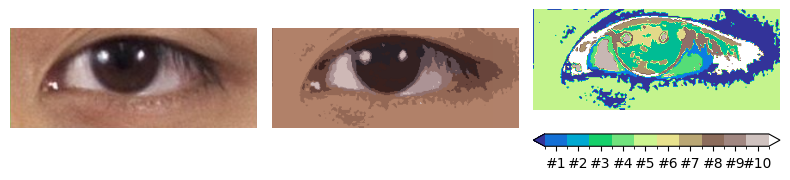

In [15]:
image = EyeTraumaAnalysis.Image(f"data/01_raw/{img_file_num}.png")
img_bgr = image.img
img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
centers, kmeans_masks, res_hsv, clusters = EyeTraumaAnalysis.create_kmeans(img_hsv)
res_bgr = np.uint8(cv2.cvtColor(res_hsv, cv2.COLOR_HSV2BGR))
masks_summed = EyeTraumaAnalysis.get_masked_sums(kmeans_masks)
plot_kmeans_subplots_view_simple(img_bgr, res_bgr, masks_summed)

with pd.option_context("display.precision", 3, "display.width",100):
    print(clusters)

## Run on HSV when BGR is float32 from 0-255  - winner!

    center                      min                    max                   ct           
         H      S        V        H      S      V        H      S      V      #          %
0    0.000  0.080   26.615  277.500  0.008  159.0  354.545  0.086  255.0     99  2.948e-03
1  289.861  0.244   38.837  174.462  0.101  126.0  268.235  0.528  167.0   8334  2.482e-01
2  240.956  0.371   56.646    0.000  0.067   22.0    0.000  0.103   30.0     26  7.743e-04
3  232.674  0.374  105.894  258.462  0.050   16.0  348.000  0.609   80.0   1046  3.115e-02
4  288.465  0.112  116.187  167.500  0.097  159.0  271.765  0.492  192.0  13540  4.032e-01
5  223.924  0.400  149.668  210.811  0.055  176.0  276.000  0.490  255.0   2535  7.549e-02
6  221.492  0.391  175.701  258.750  0.042   80.0  354.000  0.211  174.0    268  7.981e-03
7    4.437  0.054  191.621  218.182  0.106   79.0  267.000  0.612  132.0   3593  1.070e-01
8  224.193  0.308  197.039    0.000  0.016  141.0   15.000  0.079  255.0     29  8.636e-04

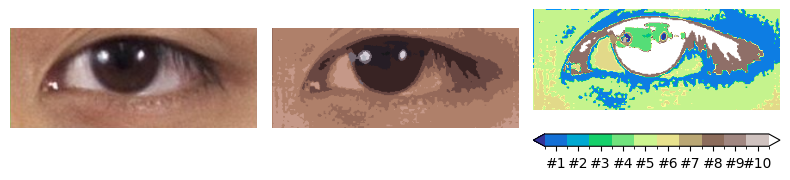

In [30]:
image = EyeTraumaAnalysis.Image(f"data/01_raw/{img_file_num}.png")
img_bgr = image.img
# HSV floats are from (0-360,0-1,0-1) while uint8s are 0-255 for all channels
img_hsv = cv2.cvtColor(np.float32(img_bgr), cv2.COLOR_BGR2HSV)  # needs to be float32, not the default float64
centers, kmeans_masks, res_hsv, clusters = EyeTraumaAnalysis.create_kmeans(img_hsv)
masks_summed = EyeTraumaAnalysis.get_masked_sums(kmeans_masks)
res_bgr = np.uint8(cv2.cvtColor(res_hsv, cv2.COLOR_HSV2BGR))
plot_kmeans_subplots_view_simple(img_bgr, res_bgr, masks_summed)

with pd.option_context("display.precision", 3, "display.width",100):
    print(clusters)

##  Run on HSV when BGR is float32 from 0-1

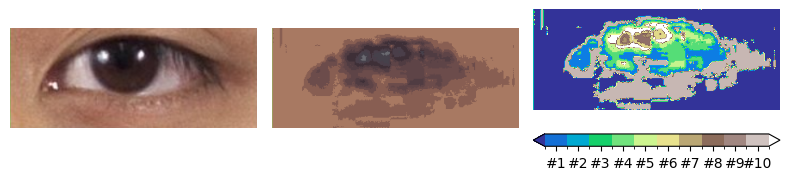

In [17]:
image = EyeTraumaAnalysis.Image(f"data/01_raw/{img_file_num}.png")
img_bgr = image.img
img_hsv = cv2.cvtColor(np.float32(img_bgr)/255.0, cv2.COLOR_BGR2HSV)  # needs to be float32, not the default float64
centers, kmeans_masks, res_hsv, clusters  = EyeTraumaAnalysis.create_kmeans(img_hsv)
masks_summed = EyeTraumaAnalysis.get_masked_sums(kmeans_masks)
res_bgr = np.uint8((cv2.cvtColor(res_hsv, cv2.COLOR_HSV2BGR)) *255)
plot_kmeans_subplots_view_simple(img_bgr, res_bgr, masks_summed)

## Run on BGR uint8

  center                 min               max                  ct        center
       B    G    R    A    B    G    R  A    B    G    R  A      #      %      V
0     33   22   25  254   37   25   19 -1   37   25   19 -1   2165  0.064     33
1     52   34   34  255   15    7    8 -1   15    7    8 -1   1370  0.041     52
2     69   47   46  255  -85  -92 -100 -1  -85  -92 -100 -1    666  0.020     69
3     96   66   62  255 -126  126  125 -1 -126  126  125 -1   1251  0.037     96
4    130   92   80  255  -46  -55  -59 -1  -46  -55  -59 -1     89  0.003    130
5    160  113   94  254   50   36   29 -1   50   36   29 -1   1694  0.050    160
6    176  150  147  255  117   97   76 -1  117   97   76 -1   9981  0.297    176
7    181  134  109  255   94   72   57 -1   94   72   57 -1   3938  0.117    181
8    201  181  179  255   69   47   40 -1   69   47   40 -1   2214  0.066    201
9    241  229  232  255 -106  117   90 -1 -106  117   90 -1  10211  0.304    241


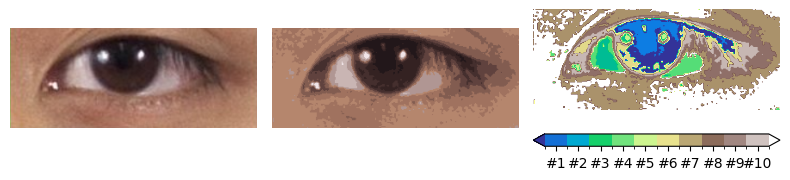

In [18]:
image = EyeTraumaAnalysis.Image(f"data/01_raw/{img_file_num}.png")
img_bgr = image.img
centers, kmeans_masks, res_bgr, clusters = EyeTraumaAnalysis.create_kmeans(img_bgr)
masks_summed = EyeTraumaAnalysis.get_masked_sums(kmeans_masks)
plot_kmeans_subplots_view_simple(img_bgr, res_bgr, masks_summed)

clusters[("center","V")] = np.max(centers[["B","G","R"]], axis=1)
clusters = clusters.sort_values(by=("center","V"))
with pd.option_context("display.precision", 3, "display.width",100):
    print(clusters)

## Run on old version of function (on HSV when BGR is uint8)

     H    S    V     ct         %
0  140   54   41   1132  0.033712
1  120  101   53   3487  0.103845
2  124   51   93   1422  0.042348
3  114  109  101   2468  0.073498
4  111  106  143   5279  0.157211
5  121   51  153   1400  0.041693
6  110  106  167  10031  0.298728
7  109  100  185   7024  0.209178
8    2   13  191     29  0.000864
9  121   31  195   1307  0.038923


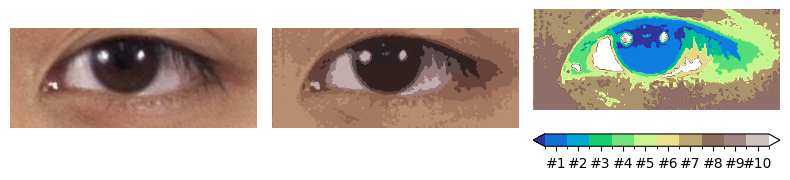

In [19]:
image = EyeTraumaAnalysis.Image(f"data/01_raw/{img_file_num}.png")
img_bgr = image.img
# HSV floats are from (0-360,0-1,0-1) while uint8s are 0-255 for all channels
img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)  # needs to be float32, not the default float64
centers, ranges, res_hsv, kmeans_masks = EyeTraumaAnalysis.kmeans.create_kmeans_old(img_hsv)
masks_summed = EyeTraumaAnalysis.get_masked_sums(kmeans_masks)
res_bgr = cv2.cvtColor(res_hsv, cv2.COLOR_HSV2BGR)
plot_kmeans_subplots_view_simple(img_bgr, res_bgr, masks_summed)

centers["ct"] = np.sum(kmeans_masks, axis=(1,2))
centers["%"] = centers["ct"] / centers["ct"].sum()
print(centers)

# Run and save on all images

In [50]:
np.sum(kmeans_masks[0])

3549

In [53]:
np.product(kmeans_masks[0].shape)

33579

In [54]:
spatial_metrics

{'x': {'mean': 0.5000517774908017, 'sd': 0.08748618695948956},
 'y': {'mean': 0.2996027574191999, 'sd': 0.11597113998081857}}

In [71]:
print("Saved... ", end="")
for img_file_num in range(14000,14580):
    image = EyeTraumaAnalysis.Image(f"data/01_raw/{img_file_num}.png")
    img_bgr = image.img
    # HSV floats are from (0-360,0-1,0-1) while uint8s are 0-255 for all channels
    img_hsv = cv2.cvtColor(np.float32(img_bgr), cv2.COLOR_BGR2HSV)  # needs to be float32, not the default float64
    centers, kmeans_masks, res_hsv, clusters = EyeTraumaAnalysis.create_kmeans(img_hsv)
    masks_summed = EyeTraumaAnalysis.get_masked_sums(kmeans_masks)
    res_bgr = np.uint8(cv2.cvtColor(res_hsv, cv2.COLOR_HSV2BGR))
    centers_indices = np.argsort(centers, axis=0)  # get ranks

    # Save actual kmeans images
    plt.imsave(f"data/02_kmeans/{img_file_num}_kmeanscolor.png", np.uint8(res_bgr))
    plt.imsave(f"data/02_kmeans/{img_file_num}_grayscale.png", masks_summed)
    print(img_file_num, end=" ")

    ## Save Clustered View figure
    plot_kmeans_subplots_view(img_bgr, res_bgr, masks_summed)
    """fig, axs = plt.subplots(2, 2, figsize=(12,6))
    im0=axs.flat[0].imshow(img_bgr)
    im1=axs.flat[1].imshow(res_bgr)
    im2=axs.flat[2].imshow(masks_summed, cmap="gray")
    im3=axs.flat[3].imshow(masks_summed, cmap="terrain")
    plt.colorbar(im3,ax=axs.flat[3], shrink=0.8)"""
    plt.savefig(f"outputs/clustered_view/{img_file_num}_clustered_view.png", format="png")
    plt.close()  # close to prevent overconsumption of memory

    ## Save Per Cluster Masking figure
    K = kmeans_masks.shape[0]
    row_ct = int(np.sqrt(K))
    col_ct = int(np.ceil(K/row_ct))
    fig, axs = plt.subplots(row_ct, col_ct, figsize=(12,6), sharex=True, sharey=True)
    for ind in range(row_ct*col_ct):
        if ind < K:
            target1 = image.img.copy()
            target1[kmeans_masks[ind].astype(bool)] = [127,255,127,255]   # bright green
            axs.flat[ind].imshow(target1)

            spatial_metrics = EyeTraumaAnalysis.get_spatial_metrics(kmeans_masks[ind])
            hsv_center = centers.iloc[ind]
            hsv_rank = centers_indices.iloc[ind]
            area_pct = np.sum(kmeans_masks[ind]) / np.product(kmeans_masks[ind].shape)

            # Draw left title
            axs.flat[ind].set_title(
                "  COLOR:" + "\n" +
                " H , S , V " + "\n" +
                f"#{hsv_rank[0]+1:.0f}, #{hsv_rank[1]+1:.0f}, #{hsv_rank[2]+1:.0f}" + "\n" +
                f"{hsv_center[0]:>2.0f}, {hsv_center[1]:>2.0f}, {hsv_center[2]:>2.0f}",
                fontsize=8, loc="left", fontfamily="monospace",
            )
            # Draw right title
            axs.flat[ind].set_title(
                f"LOCATION:   " + "\n"+
                f"μ: ({spatial_metrics['x']['mean']:5.1%}, {spatial_metrics['y']['mean']:5.1%})" + "\n" +
                f"σ: ({spatial_metrics['x']['sd']:5.1%}, {spatial_metrics['y']['sd']:5.1%})" + "\n" +
                f"Area: {area_pct:^6.2%}",
                fontsize=8, loc="right", fontfamily="monospace",
            )
            # Draw center title
            axs.flat[ind].set_title(
                f"#{hsv_rank[2]+1:.0f}  ",
                fontsize=16, loc="center",fontweight="bold",
            )
        else:
            axs.flat[ind].axis("off")  # remove axes for empty cells
        # save axis as singular image
        if ind < 10:
            extent = axs.flat[ind].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    plt.tight_layout()
    plt.savefig(f"outputs/per_cluster_mask/{img_file_num}_per_cluster_mask.png", format="png")
    plt.close()  # close to prevent overconsumption of memory


Saved... 14000 14001 14002 14003 14004 14005 14006 14007 14008 14009 14010 14011 14012 14013 14014 14015 14016 14017 14018 14019 14020 14021 14022 14023 14024 14025 14026 14027 14028 14029 14030 14031 14032 14033 14034 14035 14036 14037 14038 14039 14040 14041 14042 14043 14044 14045 14046 14047 14048 14049 14050 14051 14052 14053 14054 14055 14056 14057 14058 14059 14060 14061 14062 14063 14064 14065 14066 14067 14068 14069 14070 14071 14072 14073 14074 14075 14076 14077 14078 14079 14080 14081 14082 14083 14084 14085 14086 14087 14088 14089 14090 14091 14092 14093 14094 14095 14096 14097 14098 14099 14100 14101 14102 14103 14104 14105 14106 14107 14108 14109 14110 14111 14112 14113 14114 14115 14116 14117 14118 14119 14120 14121 14122 14123 14124 14125 14126 14127 14128 14129 14130 14131 14132 14133 14134 14135 14136 14137 14138 14139 14140 14141 14142 14143 14144 14145 14146 14147 14148 14149 14150 14151 14152 14153 14154 14155 14156 14157 14158 14159 14160 14161 14162 14163 14164 1

# Ethan's old code

In [10]:
### Per Cluster Masking ### <-- for individual image use
#image = EyeTraumaAnalysis.Image("data/01_raw/11000.jpg")
#draw_cluster_masking(image.img)
def draw_cluster_masking(img, K=10):
    row_ct = int(np.sqrt(K))
    col_ct = int(np.ceil(K/row_ct))
    fig, axs = plt.subplots(row_ct, col_ct, figsize=(12,6), sharex=True, sharey=True)
    for ind in range(row_ct*col_ct):
        if ind < K:
            #target1 = cv2.bitwise_and(image.img,image.img, mask=~kmeans_thresholds[ind])
            target1 = img.copy()
            target1[kmeans_thresholds[ind].astype(bool)] = [127,255,127,255]
            axs.flat[ind].imshow(target1)
            spatial_metrics = EyeTraumaAnalysis.get_spatial_metrics(kmeans_thresholds[ind])
            hsv_rank = centers_indices[ind]
            hsv_center = centers_sorted[ind]
            # Draw left title
            axs.flat[ind].set_title(
                "HSV \n"+
                f"#{hsv_rank[0]+1}, #{hsv_rank[1]+1}, #{hsv_rank[2]+1}" + "\n" +
                f"({hsv_center[0]}, {hsv_center[1]}, {hsv_center[2]})",
                fontsize=8, loc="left"
            )
            # Draw right title
            axs.flat[ind].set_title(
                f"Location:" + "\n"+
                f"({spatial_metrics['x']['mean']*100:.1f}, {spatial_metrics['y']['mean']:.1%})" + "\n" +
                f"({spatial_metrics['x']['sd']*100:.1f}, {spatial_metrics['y']['sd']:.1%})",
                fontsize=8, loc="right", fontfamily="monospace",
            )
            # axs.flat[ind].set_title(
            #     f"HSV center: [{centers_sorted[ind,0]},{centers_sorted[ind,1]},{centers_sorted[ind,2]}]" )
            #axs.flat[ind].imshow(kmeans_thresholds[ind], cmap="gray")
        else:
            # remove axes for empty cells
            axs.flat[ind].axis("off")

In [13]:
#image = EyeTraumaAnalysis.Image("data/01_raw/11000.jpg")
#draw_separate_clusters(image.img, filename=None)
def draw_separate_clusters(img, filename=None, labelled=True, K_val=10):
    img_bgr = image.img
    img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    Z_hsv = img_hsv.reshape((-1,3))
    # convert to np.float32
    Z_hsv = np.float32(Z_hsv)
    # calculate K-means segmentation
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    ret,label,centers=cv2.kmeans(Z_hsv,K_val,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
    # Now convert back into uint8, and make original image
    centers = np.uint8(centers)
    res_hsv = centers[label.flatten()]
    res_hsv2 = res_hsv.reshape(img_hsv.shape)
    res_bgr = cv2.cvtColor(res_hsv2, cv2.COLOR_HSV2BGR)
    centers_sorted = centers[centers[:, 2].argsort()]
    kmeans_thresholds = []
    for ind in range(K_val):
        kmeans_thresholds.append(cv2.inRange(res_hsv2,centers_sorted[ind],centers_sorted[ind]))
    centers_indices = centers_sorted.argsort(axis=0)
    for i in range(K_val):
        # propogate variables
        target = img.copy()
        # target[kmeans_thresholds[i].astype(bool)] = [127,255,127,255]
        target[np.where(kmeans_thresholds[i])] = [127,255,127,255]
        spatial_metrics = EyeTraumaAnalysis.get_spatial_metrics(kmeans_thresholds[i])
        hsv_rank, hsv_center = centers_indices[i], centers_sorted[i]
        # generate plot
        if labelled:
            plt.title(
                    "HSV \n"+
                    f"#{hsv_rank[0]+1}, #{hsv_rank[1]+1}, #{hsv_rank[2]+1}" + "\n" +
                    f"({hsv_center[0]}, {hsv_center[1]}, {hsv_center[2]})",
                    fontsize=8, loc="left"
                )
            plt.title(
                    f"Location:" + "\n"+
                    f"({spatial_metrics['x']['mean']*100:.1f}, {spatial_metrics['y']['mean']:.1%})" + "\n" +
                    f"({spatial_metrics['x']['sd']*100:.1f}, {spatial_metrics['y']['sd']:.1%})",
                    fontsize=8, loc="right", fontfamily="monospace",
                )
        plt.imshow(target)
        # save plot as PNG
        if filename is not None:
            if labelled:
                fpath = "C:/Users/ethan/PycharmProjects/EyeTraumaAnalysis/data/kmeans_indiv_clusters/labelled/"
            else:
                fpath = "C:/Users/ethan/PycharmProjects/EyeTraumaAnalysis/data/kmeans_indiv_clusters/non-labelled/"
            plt.savefig(f"{fpath}{filename}_v{i}.png", format="png")
        # plt.clf()

In [14]:
### Running Code on Several Images ###
from PIL import Image as PILimg

K = 10
# save_directory = "C:\\Users\\ethan\\PycharmProjects\\EyeTraumaAnalysis\\data\\kmeans_clustering_applied" # data/kmeans_clustering_applied; hard coded for PC
# NOTE: While this isn't a preferable implementation, the previous code, which was flexible per system, ran into PermissionError [Errno 13]

for image_sample in images:
    # image = EyeTraumaAnalysis.Image(f"data/01_raw/{image_sample}")
    image = EyeTraumaAnalysis.Image(f"data/01_raw/Ergonautus/Full Dataset/{image_sample}")

    ## Clustered View
    img_bgr = image.img
    img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    Z_hsv = img_hsv.reshape((-1,3))
    Z_hsv = np.float32(Z_hsv)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    ret,label,centers=cv2.kmeans(Z_hsv,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
    centers = np.uint8(centers)
    res_hsv = centers[label.flatten()]
    res_hsv2 = res_hsv.reshape(img_hsv.shape)
    res_bgr = cv2.cvtColor(res_hsv2, cv2.COLOR_HSV2BGR)
    centers_sorted = centers[centers[:, 2].argsort()]
    kmeans_thresholds = []
    for ind in range(K):
        kmeans_thresholds.append(cv2.inRange(res_hsv2,centers_sorted[ind],centers_sorted[ind]))
    # center indices
    centers_indices = centers_sorted.argsort(axis=0)
    ##
    summed_image = np.zeros(kmeans_thresholds[0].shape)
    for ind in range(K):
        summed_image += int(ind * 25) * kmeans_thresholds[ind] / 255
    plt.imsave(f"C:/Users/ethan/PycharmProjects/EyeTraumaAnalysis/data/all_clusters_indicated/{image_sample.split('.PNG')[0]}.png", summed_image)
    fig, axs = plt.subplots(2, 2, figsize=(12,6))
    im0=axs.flat[0].imshow(img_bgr)
    im1=axs.flat[1].imshow(res_bgr)
    im2=axs.flat[2].imshow(summed_image, cmap="gray")
    im3=axs.flat[3].imshow(summed_image, cmap="terrain")
    plt.colorbar(im3,ax=axs.flat[3], shrink=0.8)
    save_directory = f"{directory_path}".replace("src", "data")
    # plt.savefig(f"{save_directory}\\kmeans_clustering_applied\\ergonautus-10k\\clustered_view\\{image_sample.split('.PNG')[0]}.png",
    #             format='png')

    ## Per Cluster Masking
    row_ct = int(np.sqrt(K))
    col_ct = int(np.ceil(K/row_ct))
    fig, axs = plt.subplots(row_ct, col_ct, figsize=(12,6), sharex=True, sharey=True)
    for ind in range(row_ct*col_ct):
        if ind < K:
            #target1 = cv2.bitwise_and(image.img,image.img, mask=~kmeans_thresholds[ind])
            target1 = image.img.copy()
            target1[kmeans_thresholds[ind].astype(bool)] = [127,255,127,255]
            axs.flat[ind].imshow(target1)
            spatial_metrics = EyeTraumaAnalysis.get_spatial_metrics(kmeans_thresholds[ind])
            hsv_rank = centers_indices[ind]
            hsv_center = centers_sorted[ind]
            # Draw left title
            axs.flat[ind].set_title(
                "HSV \n"+
                f"#{hsv_rank[0]+1}, #{hsv_rank[1]+1}, #{hsv_rank[2]+1}" + "\n" +
                f"({hsv_center[0]}, {hsv_center[1]}, {hsv_center[2]})",
                fontsize=8, loc="left"
            )
            # Draw right title
            axs.flat[ind].set_title(
                f"Location:" + "\n"+
                f"({spatial_metrics['x']['mean']*100:.1f}, {spatial_metrics['y']['mean']:.1%})" + "\n" +
                f"({spatial_metrics['x']['sd']*100:.1f}, {spatial_metrics['y']['sd']:.1%})",
                fontsize=8, loc="right", fontfamily="monospace",
            )
            # axs.flat[ind].set_title(
            #     f"HSV center: [{centers_sorted[ind,0]},{centers_sorted[ind,1]},{centers_sorted[ind,2]}]" )
            #axs.flat[ind].imshow(kmeans_thresholds[ind], cmap="gray")
        else:
            # remove axes for empty cells
            axs.flat[ind].axis("off")
        # save axis as singular image
        if (ind < 10):
            extent = axs.flat[ind].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
            # fig.savefig(f"C:/Users/ethan/PycharmProjects/EyeTraumaAnalysis/data/kmeans_indiv_clusters/{image_sample.split('.PNG')[0]}_v{ind}.png", format="png", bbox_inches = extent.expanded(1.1, 1.2))
    save_dir = "C:/Users/ethan/PycharmProjects/EyeTraumaAnalysis/data"
    # plt.savefig(f"{save_dir}\\kmeans_clustering_applied\\ergonautus-10k\\per_cluster_mask\\{image_sample.split('.PNG')[0]}.png", format='png')

    # row_ct = int(np.sqrt(K))
    # col_ct = int(np.ceil(K/row_ct))
    # fig, axs = plt.subplots(row_ct, col_ct, figsize=(12,6), sharex=True, sharey=True)
    # for ind in range(row_ct*col_ct):
    #     if ind < K:
    #         target1 = cv2.bitwise_and(image.img,image.img, mask=~kmeans_thresholds[ind])
    #         axs.flat[ind].imshow(target1)
    #         axs.flat[ind].set_title(
    #         f"Mean: {round(snd.mean(target1), 3)}\nStd: {round(snd.standard_deviation(target1), 3)}"
    #     )
    #         # axs.flat[ind].set_title(
    #         #     f"HSV center: [{centers_sorted[ind,0]},{centers_sorted[ind,1]},{centers_sorted[ind,2]}]" )
    #         #axs.flat[ind].imshow(kmeans_thresholds[ind], cmap="gray")
    #     else:
    #         # remove axes for empty cells
    #         axs.flat[ind].axis("off")
    # # plt.savefig(f"{save_directory}\\kmeans_clustering_applied\\K-{K}\\per_cluster_mask\\{image_sample.split('.jpg')[0]}.png", format='png')
    # plt.savefig(f"{save_directory}\\kmeans_clustering_applied\\ergonautus-10k\\per_cluster_mask\\{image_sample.split('.PNG')[0]}.png", format='png')

    # close to prevent overconsumption of memory
    plt.close()

NameError: name 'images' is not defined